In [2]:
# include libraries
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import pandas as pd

# Functions

In [3]:
def CSV_Read_Lidar_data(data_path):
    rows = []
    with open(data_path, 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            rows.append(row)

    dataframe = pd.DataFrame([rows[0], rows[1], rows[2], rows[3]], ['Rho', 'Alpha', 'X', 'Y'])

    return dataframe

In [4]:
def covarience_line_fitting(points_in_line, line_alpha_rho, sigma_angle=0, sigma_dist=.005):
    sigma_angle = sigma_angle * np.ones(len(points_in_line))
    sigma_dist = sigma_dist * np.ones(len(points_in_line))

    data = np.array(points_in_line)

    #INPUIT IS X AND Y POINTS WITHIN A LINE
    dist = line_alpha_rho[1]  # whatever positions stores the distances from 0,0
    angle = line_alpha_rho[0]  # whatever positions stores the angles with the x axis
    
    x = data[:,0]
    y = data[:,1]

    n = len(x)
    x_bar = sum(x) / n
    y_bar = sum(y) / n

    S_x2 = sum((x - x_bar) ** 2)
    S_y2 = sum((y - y_bar) ** 2)
    S_xy = sum((x - x_bar) * (y - y_bar))

    # line paramters based on inputs data
    alpha = 0.5 * math.atan2(-2 * S_xy, S_y2 - S_x2)
    rho = x_bar * math.cos(alpha) + y_bar * math.sin(alpha)

    C_l = np.zeros(2)
    for i in range(0, n - 1):
        # The covariance of the measurement
        C_m = np.array([[sigma_angle[i], 0],
                        [0, sigma_dist[i]]])
        A = np.zeros((2, 2))

        # The jacobian of the line fit with respect to x and y
        A[1, 0] = ((y_bar - y[i]) * (S_y2 - S_x2) + 2 * S_xy * (x_bar - x[i])) / ((S_y2 - S_x2) ** 2 + 4 * S_xy ** 2)

        A[1, 1] = ((x_bar - x[i]) * (S_y2 - S_x2) - 2 * S_xy * (y_bar - y[i])) / ((S_y2 - S_x2) ** 2 + 4 * S_xy **2)

        A[0, 0] = math.cos(alpha) / n - x_bar * math.sin(alpha) * A[1, 0] + y_bar * math.cos(alpha) * A[1, 0]
        A[0, 1] = math.sin(alpha) / n - x_bar * math.sin(alpha) * A[1, 1] + y_bar * math.cos(alpha) * A[1, 1]

        # Jacobian of function converting dist and angle to x and y

        B = np.array([[math.cos(angle), -dist * math.sin(angle)],
                      [math.sin(angle), -dist * math.cos(angle)]])
        J = A @ B
        C_l = C_l + J * C_m * J.T

    return rho, alpha, C_l

In [5]:
# Bunch of algorithms for split and merge

def GetPolar(X, Y):
    # center the data
    X = X - np.mean(X)
    Y = Y - np.mean(Y)
    # fit line through the first and last point (X and Y contains 2 points, start and end of the line)
    k, n = np.polyfit(X, Y, 1)
    alpha = math.atan(-1 / k)  # in radians
    ro = n / (math.sin(alpha) - k * math.cos(alpha))
    return ro, alpha

def CheckPolar(ro, alpha):
    if ro < 0:
        alpha = alpha + math.pi
        if alpha > math.pi:
            alpha = alpha - 2 * math.pi
        ro = -ro
    return ro, alpha

def getDistance(P, Ps, Pe):  # point to line distance, where the line is given with points Ps and Pe
    if np.all(np.equal(Ps, Pe)):
        return np.linalg.norm(P - Ps)
    return np.divide(np.abs(np.linalg.norm(np.cross(Pe - Ps, Ps - P))), np.linalg.norm(Pe - Ps))

def GetMostDistant(P):
    dmax = 0
    index = -1
    for i in range(1, P.shape[0]):
        d = getDistance(P[i, :], P[0, :], P[-1, :])
        if (d > dmax):
            index = i
            dmax = d
    return dmax, index

def points_within_radius(mainpoint, points, r):
    result = []
    for point in points:
        if math.dist(mainpoint, point) <= r:
            result.append(point)
    return result

def gap_detection(lines, points, threshold):
    good_lines = []
    points_in_thresh_total = []
    for i in range(len(lines)):
        # get point 1 and point 2 of the line
        point_1 = lines[i][0]
        point_2 = lines[i][1]

        # get the distance of the line, then take a certain percentage of it (remember its based off both sides)
        line_dist = math.dist(point_2, point_1)
        r = line_dist / 2 * 0.10
        # print(r)

        # check all the points to see if they fall in theshold, store if they do
        points_in_thresh = []

        for j in range(len(points)):
            # distance = point_to_line_distance(points[j], lines[i])
            distance = getDistance(points[j], lines[i][0], lines[i][1])
            if distance <= (threshold * 1):
                # if distance < r:
                points_in_thresh.append(points[j])
        
        if len(points_in_thresh) <= 5 and line_dist <= 0.3:
            good_lines.append(lines[i])
            points_in_thresh_total.append(points_in_thresh)
            continue

        # check to see what % of points are between the threshold of the first and last point (might need my own threshold)
        p1_points = points_within_radius(point_1, points_in_thresh, r)
        p2_points = points_within_radius(point_2, points_in_thresh, r)
        # print(len(p1_points))
        # print(len(p2_points))
        # print(len(points_in_thresh))

        percent_in_radius = (len(p1_points) + len(p2_points)) / (len(points_in_thresh))
        # print(percent_in_radius)

        if percent_in_radius <= 0.40:
            # print("good line")
            good_lines.append(lines[i])
            points_in_thresh_total.append(points_in_thresh)
        # else:
        #     print("bad line")
        # plt.show()
        # print("\n")
        
    return good_lines, points_in_thresh_total

def SplitAndMerge(P, threshold):
    d, ind = GetMostDistant(P)
    if d > threshold:
        P1 = SplitAndMerge(P[:ind + 1, :], threshold)  # split and merge left array
        P2 = SplitAndMerge(P[ind:, :], threshold)  # split and merge right array
        # there are 2 "d" points, so exlude 1 (for example from 1st array)
        points = np.vstack((P1[:-1, :], P2))
    else:
        points = np.vstack((P[0, :], P[-1, :]))
    return points

def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result

'~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'

def Algorithm_split_and_merge(inputdataframe, threshold=0.3, plot=False):

    P = np.array([list(inputdataframe['X']), list(inputdataframe['Y'])]).T

    points = SplitAndMerge(P, threshold)

    lines = []
    for i in range(len(points) - 1):
        lines.append([points[i], points[i + 1]])
        # plt.plot([points[i][0], points[i+1][0]], [points[i][1], points[i+1][1]], '-o')
    # final_lines = lines
    final_lines, points_in_line = gap_detection(lines, P, threshold)

    # flatten it to get the shitty points
    flat_list = flatten(final_lines)
    flat_list.append(flat_list[0])
    flat_list = np.array(flat_list)

    #convert from xy back to alpha rho
    alpha_rho = []
    for i in range(len(final_lines)):
        alpha, rho = GetPolar([final_lines[i][0][0], final_lines[i][1][0]], [final_lines[i][0][1], final_lines[i][1][1]])
        alpha_rho.append([alpha, rho])

    if plot==True:
        plt.figure()
        plt.title('og')
        plt.scatter(P[:, 0], P[:, 1], c='black')
        plt.plot(points[:, 0], points[:, 1])

        plt.figure()
        plt.title('with gap detection')
        plt.scatter(P[:, 0], P[:, 1], c='black')
        plt.plot(flat_list[:, 0], flat_list[:, 1], '-o')

        plt.figure()
        plt.title('actual Lines')
        plt.scatter(P[:, 0], P[:, 1], c='black')
        for i in range(len(final_lines)):
            tmp = np.array(final_lines[i])
            plt.plot(tmp[:, 0], tmp[:, 1], '-o')
        # print(len(lines))
        # print(len(final_lines))
        plt.scatter(0, 0, c='red')  # replace this with the origin point
        plt.show()

    return final_lines, points_in_line, alpha_rho

# Algorithm

In [6]:
# Load datapath and put into dataframe
# path to csv data
file_path = 'Data/'
file_name = 'Hallway_Lidar_data_dinosars2_GT'

data_path = file_path + file_name + '.csv'
gt_map_df = CSV_Read_Lidar_data(data_path)
gt_map_df = gt_map_df.astype(float)

# Delete any column that has an inf in the rho spot
inf_cols = gt_map_df.loc['Rho'][np.isfinite(gt_map_df.loc['Rho'])]
gt_map_df = gt_map_df[inf_cols.index].transpose().reset_index(drop=True)

In [7]:
# # Plot the ground truth data
# plt.figure()
# plt.scatter(gt_map_df['X'], gt_map_df['Y'], s=1)
# plt.show()

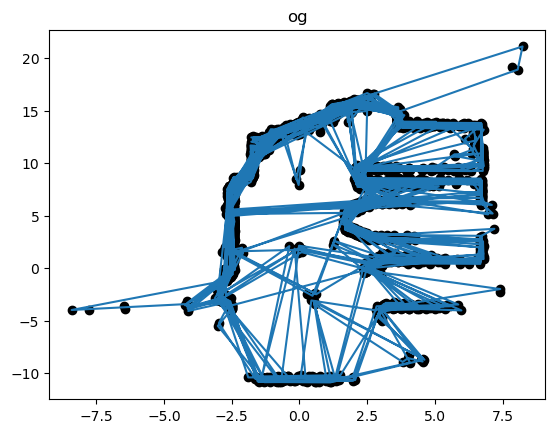

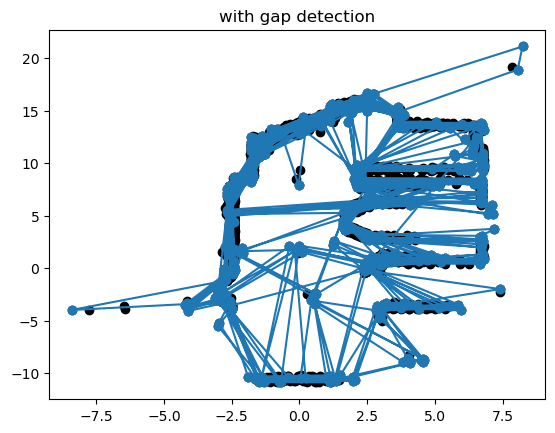

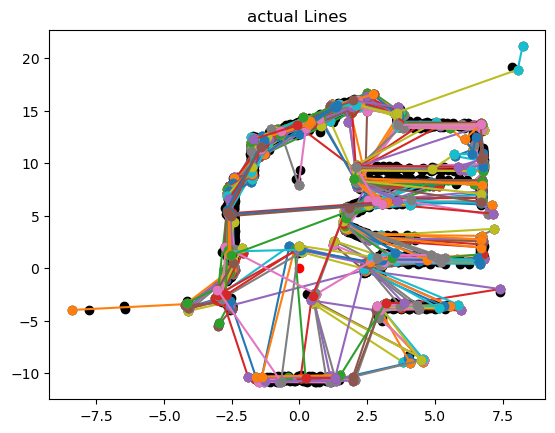

,0,1,2,3,4,5,6,7,8,9,...,571,572,573,574,575,576,577,578,579,580
Alpha,-1.03981,-0.383309,1.526495,0.638129,-0.188001,-0.000562,-1.418704,-0.925223,-0.597129,-0.22738,...,0.658228,-0.291062,-0.822145,0.39713,-0.194754,0.22908,1.488575,-0.521463,-1.526596,-0.086171
rhos,1.206585,2.612086,3.023006,3.772561,0.902915,2.369232,-14.324943,-10.911675,-7.340284,-3.793553,...,8.832506,-4.026546,-10.005871,3.195609,-3.647599,4.123613,9.708557,-0.465832,-10.579709,5.45437
Covariance,"[[0.0, 0.0], [0.0, 1.990173166957578e-06]]","[[0.0, 0.0], [0.0, 2.668656867413139e-08]]","[[0.0, 0.0], [0.0, 1.5519491250196244e-05]]","[[0.0, 0.0], [0.0, 6.381170091428956e-07]]","[[0.0, 0.0], [0.0, 5.582084038153649e-10]]","[[0.0, 0.0], [0.0, 1.5938625933846905e-13]]","[[0.0, 0.0], [0.0, 0.00016897382045690375]]","[[0.0, 0.0], [0.0, 1.605016544221093e-05]]","[[0.0, 0.0], [0.0, 2.6290655818356964e-07]]","[[0.0, 0.0], [0.0, 2.160833605184665e-09]]",...,"[[0.0, 0.0], [0.0, 6.454373995013998e-07]]","[[0.0, 0.0], [0.0, 5.4336582211927415e-09]]","[[0.0, 0.0], [0.0, 3.47374145606164e-06]]","[[0.0, 0.0], [0.0, 1.2580049184310083e-08]]","[[0.0, 0.0], [0.0, 1.068176654471579e-09]]","[[0.0, 0.0], [0.0, 3.283966428655696e-09]]","[[0.0, 0.0], [0.0, 1.0489859329966523e-05]]","[[0.0, 0.0], [0.0, 5.954666851611969e-08]]","[[0.0, 0.0], [0.0, 1.1621003436979154e-05]]","[[0.0, 0.0], [0.0, 8.548719959325493e-11]]"
Lines (endpoints),"[[2.487957967248425, 0.01444768502396881], [3....","[[3.0334424453202153, 0.3360523922674271], [4....","[[4.0365435785490815, 2.7848752270671175], [2....","[[2.524742050287297, 2.861386632920483], [1.70...","[[1.7036936688000486, 3.9262997438873852], [2....","[[2.425402696968639, 7.707387399412793], [2.49...","[[2.4963306077244356, 14.944947321560019], [1....","[[1.9544061069013128, 14.87213154760631], [0.8...","[[0.8683256894527143, 14.22151604533686], [-1....","[[-1.2636370145605567, 11.112383985299513], [-...",...,"[[0.3884105223406078, 14.00378737975383], [0.1...","[[0.1297014328658093, 14.340912959039747], [-0...","[[-0.08685972082818699, 13.593835922633454], [...","[[-1.7228652985174209, 12.25066054924389], [-1...","[[-1.4337649361437474, 11.559250683249628], [-...","[[2.8246335203619966, 6.381498438284805], [2.0...","[[2.08792332919455, 9.606373563329377], [4.898...","[[4.898158290992049, 9.393750758946666], [5.72...","[[5.722576659624634, 10.834098629720916], [6.3...","[[6.383664240754818, 10.86286314463395], [6.50..."
Points within line,"[[2.487957967248425, 0.01444768502396881], [2....","[[2.708264713203799, 0.2048381760446499], [3.0...","[[4.0365435785490815, 2.7848752270671175], [3....","[[2.840347954588674, 2.7993868663497343], [2.6...","[[1.864148756658246, 3.588716569517176], [1.75...","[[2.487957967248425, 0.01444768502396881], [2....","[[2.4963306077244356, 14.944947321560019], [1....","[[2.4963306077244356, 14.944947321560019], [1....","[[0.8683256894527143, 14.22151604533686], [-1....","[[-1.2636370145605567, 11.112383985299513], [-...",...,"[[0.8152813384906988, 13.880763786628975], [0....","[[-2.516903550863029, 5.5345817897939416], [-2...","[[0.8683256894527143, 14.22151604533686], [0.7...","[[3.0334424453202153, 0.3360523922674271], [3....","[[-1.2636370145605567, 11.112383985299513], [-...","[[3.7636718931860744, 2.795016954523008], [3.4...","[[2.121899457338899, 9.39160800044413], [2.140...","[[1.864148756658246, 3.588716569517176], [1.75...","[[-1.5130608302238806, 10.566775135711378], [-...","[[4.99955371671073, -3.8611008497058075], [5.3..."


In [8]:
# apply the split and merge algorithm
Lines, points_in_line, line_alpha_rho = Algorithm_split_and_merge(gt_map_df.astype(float),threshold=0.3, plot=True)

# Do covarience line fitting, save data to lists
alphas = []
rhos = []
covars = []
for i in range(len(points_in_line)):
    rho, alpha, C_l = covarience_line_fitting(points_in_line[i], line_alpha_rho[i])
    # line_info.append([alpha, rho, C_l])
    alphas.append(alpha)
    rhos.append(rho)
    covars.append(C_l)

# Create a dataframe with the good info
ground_truth_df = pd.DataFrame([alphas, rhos, covars, Lines, points_in_line], ['Alpha','rhos' ,'Covariance', 'Lines (endpoints)', ' Points within line'])
ground_truth_df

In [9]:
ground_truth_df

,0,1,2,3,4,5,6,7,8,9,...,571,572,573,574,575,576,577,578,579,580
Alpha,-1.03981,-0.383309,1.526495,0.638129,-0.188001,-0.000562,-1.418704,-0.925223,-0.597129,-0.22738,...,0.658228,-0.291062,-0.822145,0.39713,-0.194754,0.22908,1.488575,-0.521463,-1.526596,-0.086171
rhos,1.206585,2.612086,3.023006,3.772561,0.902915,2.369232,-14.324943,-10.911675,-7.340284,-3.793553,...,8.832506,-4.026546,-10.005871,3.195609,-3.647599,4.123613,9.708557,-0.465832,-10.579709,5.45437
Covariance,"[[0.0, 0.0], [0.0, 1.990173166957578e-06]]","[[0.0, 0.0], [0.0, 2.668656867413139e-08]]","[[0.0, 0.0], [0.0, 1.5519491250196244e-05]]","[[0.0, 0.0], [0.0, 6.381170091428956e-07]]","[[0.0, 0.0], [0.0, 5.582084038153649e-10]]","[[0.0, 0.0], [0.0, 1.5938625933846905e-13]]","[[0.0, 0.0], [0.0, 0.00016897382045690375]]","[[0.0, 0.0], [0.0, 1.605016544221093e-05]]","[[0.0, 0.0], [0.0, 2.6290655818356964e-07]]","[[0.0, 0.0], [0.0, 2.160833605184665e-09]]",...,"[[0.0, 0.0], [0.0, 6.454373995013998e-07]]","[[0.0, 0.0], [0.0, 5.4336582211927415e-09]]","[[0.0, 0.0], [0.0, 3.47374145606164e-06]]","[[0.0, 0.0], [0.0, 1.2580049184310083e-08]]","[[0.0, 0.0], [0.0, 1.068176654471579e-09]]","[[0.0, 0.0], [0.0, 3.283966428655696e-09]]","[[0.0, 0.0], [0.0, 1.0489859329966523e-05]]","[[0.0, 0.0], [0.0, 5.954666851611969e-08]]","[[0.0, 0.0], [0.0, 1.1621003436979154e-05]]","[[0.0, 0.0], [0.0, 8.548719959325493e-11]]"
Lines (endpoints),"[[2.487957967248425, 0.01444768502396881], [3....","[[3.0334424453202153, 0.3360523922674271], [4....","[[4.0365435785490815, 2.7848752270671175], [2....","[[2.524742050287297, 2.861386632920483], [1.70...","[[1.7036936688000486, 3.9262997438873852], [2....","[[2.425402696968639, 7.707387399412793], [2.49...","[[2.4963306077244356, 14.944947321560019], [1....","[[1.9544061069013128, 14.87213154760631], [0.8...","[[0.8683256894527143, 14.22151604533686], [-1....","[[-1.2636370145605567, 11.112383985299513], [-...",...,"[[0.3884105223406078, 14.00378737975383], [0.1...","[[0.1297014328658093, 14.340912959039747], [-0...","[[-0.08685972082818699, 13.593835922633454], [...","[[-1.7228652985174209, 12.25066054924389], [-1...","[[-1.4337649361437474, 11.559250683249628], [-...","[[2.8246335203619966, 6.381498438284805], [2.0...","[[2.08792332919455, 9.606373563329377], [4.898...","[[4.898158290992049, 9.393750758946666], [5.72...","[[5.722576659624634, 10.834098629720916], [6.3...","[[6.383664240754818, 10.86286314463395], [6.50..."
Points within line,"[[2.487957967248425, 0.01444768502396881], [2....","[[2.708264713203799, 0.2048381760446499], [3.0...","[[4.0365435785490815, 2.7848752270671175], [3....","[[2.840347954588674, 2.7993868663497343], [2.6...","[[1.864148756658246, 3.588716569517176], [1.75...","[[2.487957967248425, 0.01444768502396881], [2....","[[2.4963306077244356, 14.944947321560019], [1....","[[2.4963306077244356, 14.944947321560019], [1....","[[0.8683256894527143, 14.22151604533686], [-1....","[[-1.2636370145605567, 11.112383985299513], [-...",...,"[[0.8152813384906988, 13.880763786628975], [0....","[[-2.516903550863029, 5.5345817897939416], [-2...","[[0.8683256894527143, 14.22151604533686], [0.7...","[[3.0334424453202153, 0.3360523922674271], [3....","[[-1.2636370145605567, 11.112383985299513], [-...","[[3.7636718931860744, 2.795016954523008], [3.4...","[[2.121899457338899, 9.39160800044413], [2.140...","[[1.864148756658246, 3.588716569517176], [1.75...","[[-1.5130608302238806, 10.566775135711378], [-...","[[4.99955371671073, -3.8611008497058075], [5.3..."


In [10]:
# write to csv
addition = '_LineData'
# with open(file_path + file_name + addition + '.csv', 'w', newline='') as file:
#   writer = csv.writer(file)

#   writer.writerow(ground_truth_df)
ground_truth_df = ground_truth_df.T
ground_truth_df.to_csv(file_path + file_name + addition + '.csv', index=False, header=True)